# Data Preparation
Most of our analyses don't work directly on the text data we preprocess above. Instead, we want something formatted more like the traditional object of free recall modeling: sequences of study events and recall events related based on item identity, serial position, and other task features. 

We'll follow the approach of the [Psifr library](https://psifr.readthedocs.io/en/latest/index.html) and represent most of our data in a long table format, with each row corresponding to a study or recall event and tracking for each event a subject index, a trial index, an input or output position, and item id. To identify items, we'll just use the text of the corresponding source unit either studied or recalled. 

Uniquely with respect to narrative recall data, we're also interested in tracking cues in narratives that connect items semantically. Given our understanding of how the Landscape and CMR models work, we'll focus on tracking:

1. Co-occurrence of idea units within the same sentence (characterized as reading "cycles" in the documentation of the Landscape model)
2. Semantic similarity between idea units as tracked in sentence embeddings corresponding to the Sentence-BERT vector space model of word semantics

Cycle identities will be included within our long table representations of the data, but semantic similarity matrices between source units for each story will be tracked separately, retrieved when relevant for analyses based on event details.

## Dataset Overview

In [189]:
from IPython.display import Markdown

def render_tex(tex_path, bib_path, csl_path):
    result = !pandoc -C --ascii {tex_path} -f latex -t markdown_mmd --bibliography {bib_path} --csl {csl_path}
    return Markdown('\n'.join(result))

render_tex('writing/BrownSchmidt_Dataset.tex', 'writing/references.bib', 'writing/main/apa.csl')

Recall for narratives, if split into idea units &ndash; "meaningful
chunks of information that convey a piece of the narrative" &ndash; that
are numbered according to chronological order, can be examined using
analytic techniques developed for free and serial list recall tasks.
This framework enables direct comparison between ideas, assumptions, and
models applied to understand how people remember sequences such as word
lists and those used to understand memory for narrative texts. To
support analysis of narrative recall this way, we considered a dataset
collected, preprocessed, and presented by Cutler et al. (2019). In
corresponding experiments, research participants read 6 distinct short
stories. Upon reading a story, participants performed immediate free
recall of the narrative twice. Three weeks later, participants performed
free recall of each narrative again. Each recall period was limited to
five minutes. Following data collection, a pair of research assistants
in the Brown-Schmidt laboratory were each instructed to independently
split stories and participant responses into idea units as defined
above, and to identify correspondences between idea units in participant
responses and corresponding studied stories reflecting recall. Following
this initial preprocessing, research assistants then compared and
discussed their results and recorded consensus decisions regarding the
segmentation and correspondence of idea units across the dataset.
Further analysis focused on the sequences of story idea units recalled
by participants on each trial as tracked by these researchers.

<div id="refs" class="references csl-bib-body hanging-indent"
markdown="1" line-spacing="2">

<div id="ref-cutler2019narrative" class="csl-entry" markdown="1">

Cutler, R., Palan, J., Polyn, S., & Brown-Schmidt, S. (2019). Semantic
and temporal structure in memory for narratives: A benefit for
semantically congruent ideas. *Context and Episodic Memory Symposium*.

</div>

</div>

Human raters have gotten us most of what we want in the spreadsheet at `data/raw/Narrative Recall Data.xlsx`. Most preprocessing using external data is devoted to identifying otherwise ambiguous relationships between source idea units.

In [190]:
# dependencies
import os
import spacy
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

# model for computing sentence embeddings
embedding_model = SentenceTransformer("stsb-distilbert-base")

# model for detecting reading cycles
nlp = spacy.load("en_core_web_trf")

# key paths
source_directory = os.path.join('data', 'raw')
text_directory = os.path.join('data', 'texts')
target_directory = os.path.join('data', 'sequences', 'human')

# names for relevant passages
passage_names = ['Fisherman', 'Supermarket', 'Flight', 'Cat', 'Fog', 'Beach']

# we use the original xlsx
data = pd.read_excel(os.path.join(
    source_directory, 'Narrative Recall Data.xlsx'), 
                     list(range(22)), engine='openpyxl')

data[0].head()

,subject,story,timeTest,serialPos,origText,recalled,posRec,recText,Observations
0,1,1,1,1.0,One fine day an old Maine man was fishing,1,1,There was once an old man fishing,NaN
1,1,1,1,2.0,on his favorite lake,0,NaN,NaN,NaN
2,1,1,1,3.0,and catching very little,1,2,He was catching very little,NaN
3,1,1,1,4.0,"Finally, he gave up",0,NaN,NaN,NaN
4,1,1,1,5.0,and walked back along the shore to his fishing...,1,3,He went back to his house,NaN


## Story Information
- Strings identifying idea units within each story
- Semantic similarity matrix between source idea units
- Cycles grouping source idea units based on co-occurence in the same sentence

Later when we process specific trials, we'll retrieve this information to identify study events in our final table.

In [191]:
all_cycles = []
all_source_units = []
all_similarities = []
story_sequence = []

for trial_index, trial in tqdm(data[0].groupby(['story', 'timeTest'])):
    
    # we only consider each story once
    if trial['timeTest'].values[0] > 1:
        continue
    
    # identify story
    story_index = trial['story'].values[0]
    story_sequence.append(story_index)
    
    # source units are reproduced perfectly in xlsx file
    source_units = [each for each in list(trial['origText']) if type(each) == str]
    
    # collect relevant text
    with open(os.path.join(
        text_directory, passage_names[story_index-1] + '.txt'), encoding='utf8') as f:
        story_text = f.read()
        
    # sort units into cycles based on co-occurence in the same sentence
    # build cycle vector assigning a cycle index to each idea unit
    cycles = []
    cycle_index = 0
    last = 0
    story_doc = nlp(story_text)
    
    for unit in source_units:
        
        # locate the unit in story_text
        unit_loc = story_text.index(unit)
        
        # find the sentence corresponding to its first character
        unit_sentence = story_doc.char_span(unit_loc, unit_loc+len(unit.strip())).sent.start
        
        # if the sentence differs from the last considered one, that's a new cycle
        if unit_sentence != last:
            cycle_index += 1
            last = unit_sentence

        cycles.append(cycle_index)
                
    # track semantic similarity between each source unit
    embeddings = embedding_model.encode(source_units)
    similarities = util.pytorch_cos_sim(embeddings, embeddings).detach().tolist()
    
    all_cycles.append(cycles)
    all_similarities.append(similarities)
    all_source_units.append(source_units)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:08<00:00,  2.18it/s]


Let's do a sanity check: lengths of cycle, similarity, and source unit vectors should be the same.

In [192]:
for i in range(len(all_source_units)):
    print(len(all_cycles[i]), len(all_similarities[i]), len(all_source_units[i]))

41 41 41
39 39 39
43 43 43
39 39 39
26 26 26
40 40 40


## Trial Information

In [193]:
results = []

# consider each unique trial
for subject_index, subject in enumerate(data):
    for trial_index, trial in enumerate(
        data[subject].groupby(['story', 'timeTest'])):
        
        # identify story, timeTest (we already have subject_index)
        story_index = trial[0][0]-1
        timeTest = trial[0][1]
        passage_name = passage_names[story_index]
        
        # build study event list based on extracted story information
        for unit_index, unit in enumerate(all_source_units[story_index]):
            results.append(
                [subject, trial_index, 'study', unit_index+1, 
                 unit, unit_index, all_cycles[story_index][unit_index], 
                 story_index, passage_name, timeTest])
        
        # we only care about the posRec column
        # create a recall event wherever a value is stored
        for serialPos, posRec in enumerate(list(trial[1]['posRec'])):
            
            # move to next entry if value can't be cast as integer
            try:
                posRec = int(posRec)
            except ValueError:
                continue
            
            results.append(
                [subject, trial_index, 'recall', posRec,
                 all_source_units[story_index][serialPos-1], serialPos-1,
                 all_cycles[story_index][serialPos-1], 
                 story_index, passage_name, timeTest])
            
results = pd.DataFrame(results, columns=[
    'subject', 'list', 'trial_type', 'position', 'item', 'item_index', 'cycle', 
    'story_index', 'story_name', 'time_test'])

results.head()

,subject,list,trial_type,position,item,item_index,cycle,story_index,story_name,time_test
0,0,0,study,1,One fine day an old Maine man was fishing,0,0,0,Fisherman,1
1,0,0,study,2,on his favorite lake,1,0,0,Fisherman,1
2,0,0,study,3,and catching very little,2,0,0,Fisherman,1
3,0,0,study,4,"Finally, he gave up",3,1,0,Fisherman,1
4,0,0,study,5,and walked back along the shore to his fishing...,4,1,0,Fisherman,1


## Store Results

In [194]:
import json

# similarities
similarity_result = {passage_names[i]: all_similarities[i] 
                     for i in range(len(all_similarities))}

with open('data/similarities.json', 'w') as f:
    f.write(json.dumps(similarity_result))
    
results.to_csv('data/psifr_sbs.csv', index=False)

## Examples

Then the data can easily be retrieved in one line, with `pivot_table` applied to retrieve trial arrays and whatnot. Right?

In [195]:
data = pd.read_csv('data/psifr_sbs.csv')
data.head()

,subject,list,trial_type,position,item,item_index,cycle,story_index,story_name,time_test
0,0,0,study,1,One fine day an old Maine man was fishing,0,0,0,Fisherman,1
1,0,0,study,2,on his favorite lake,1,0,0,Fisherman,1
2,0,0,study,3,and catching very little,2,0,0,Fisherman,1
3,0,0,study,4,"Finally, he gave up",3,1,0,Fisherman,1
4,0,0,study,5,and walked back along the shore to his fishing...,4,1,0,Fisherman,1


In [196]:
from psifr import fr
events = fr.merge_free_recall(data, list_keys=['item_index', 'cycle', 'story_index', 'story_name', 'time_test'])

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,item_index,cycle,story_index,story_name,time_test
0,0,0,One fine day an old Maine man was fishing,1.0,NaN,True,False,0,False,0,0,0,Fisherman,1
1,0,0,on his favorite lake,2.0,2.0,True,True,0,False,1,0,0,Fisherman,1
2,0,0,and catching very little,3.0,NaN,True,False,0,False,2,0,0,Fisherman,1
3,0,0,"Finally, he gave up",4.0,3.0,True,True,0,False,3,1,0,Fisherman,1
4,0,0,and walked back along the shore to his fishing...,5.0,NaN,True,False,0,False,4,1,0,Fisherman,1


### Trials Array

In [197]:
trials_df = events.pivot_table(index=['subject', 'list'], columns='output', values='input')
trials_df.head()

output        1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  ...  \
subject list                                                              ...   
0       0      NaN   2.0   4.0  10.0  16.0  18.0  20.0  22.0  29.0  33.0  ...   
        1      NaN   1.0   2.0   4.0   5.0   6.0   7.0  11.0   9.0  10.0  ...   
        2      2.0   6.0  10.0  13.0  17.0  16.0  18.0  19.0  22.0  29.0  ...   
        3      NaN   1.0   3.0   4.0   6.0  10.0   8.0  14.0  15.0  16.0  ...   
        4      NaN   1.0   2.0   3.0   4.0   5.0   6.0   7.0  10.0  15.0  ...   

output        32.0  33.0  34.0  35.0  36.0  37.0  38.0  39.0  40.0  41.0  
subject list                                                              
0       0      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        1      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        2      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        3      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        4      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 41 columns]

In [198]:
trials_df.to_numpy(na_value=0).astype('int64')

array([[ 0,  2,  4, ...,  0,  0,  0],
       [ 0,  1,  2, ...,  0,  0,  0],
       [ 2,  6, 10, ...,  0,  0,  0],
       ...,
       [ 1,  2,  3, ...,  0,  0,  0],
       [ 0,  1,  3, ...,  0,  0,  0],
       [ 2,  3,  8, ...,  0,  0,  0]], dtype=int64)

### Cycles

In [199]:
events.pivot_table(index=['subject', 'list'], columns='input', values='cycle')

input         1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  ...  \
subject list                                                              ...   
0       0      0.0   0.0   0.0   1.0   1.0   2.0   3.0   4.0   5.0   6.0  ...   
        1      0.0   0.0   0.0   1.0   1.0   2.0   3.0   4.0   5.0   6.0  ...   
        2      0.0   0.0   0.0   1.0   1.0   2.0   3.0   4.0   5.0   6.0  ...   
        3      0.0   0.0   1.0   1.0   2.0   2.0   2.0   3.0   4.0   4.0  ...   
        4      0.0   0.0   1.0   1.0   2.0   2.0   2.0   3.0   4.0   4.0  ...   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
21      13     0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   2.0   3.0  ...   
        14     0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   2.0   3.0  ...   
        15     0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   2.0   2.0  ...   
        16     0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   2.0   2.0  ...   
        17     0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   2.0   2.0  ...   

input         34.0  35.0  36.0  37.0  38.0  39.0  40.0  41.0  42.0  43.0  
subject list                                                              
0       0     24.0  25.0  26.0  27.0  28.0  28.0  29.0  30.0   NaN   NaN  
        1     24.0  25.0  26.0  27.0  28.0  28.0  29.0  30.0   NaN   NaN  
        2     24.0  25.0  26.0  27.0  28.0  28.0  29.0  30.0   NaN   NaN  
        3     17.0  18.0  18.0  19.0  19.0  19.0   NaN   NaN   NaN   NaN  
        4     17.0  18.0  18.0  19.0  19.0  19.0   NaN   NaN   NaN   NaN  
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
21      13     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        14     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        15    10.0  10.0  11.0  11.0  12.0  12.0  12.0   NaN   NaN   NaN  
        16    10.0  10.0  11.0  11.0  12.0  12.0  12.0   NaN   NaN   NaN  
        17    10.0  10.0  11.0  11.0  12.0  12.0  12.0   NaN   NaN   NaN  

[396 rows x 43 columns]

And an example visualization:

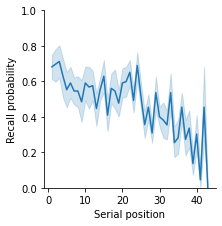

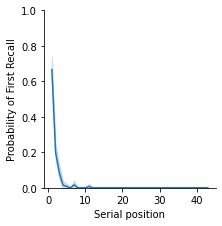

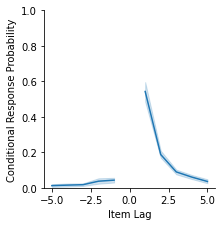

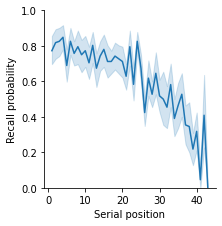

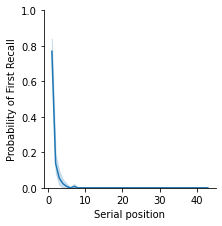

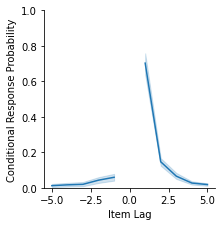

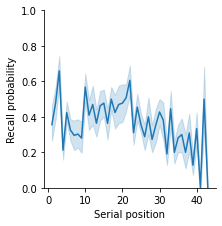

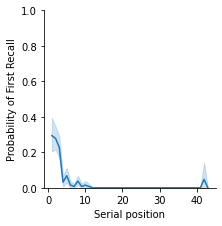

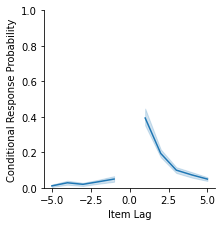

In [200]:
from narrative_cmr.Temporal_Effects import visualize_aggregate

for i in range(1, 4):
    visualize_aggregate(events.loc[(events.time_test==i)], data_query='subject > -1')
    plt.show()

In [201]:
for i in range(1, 4):
    print(fr.lag_rank(events[events.time_test==i]).agg(['mean', 'sem']))

          rank
mean  0.930938
sem   0.006041
          rank
mean  0.959167
sem   0.006565
          rank
mean  0.889666
sem   0.008982


In [223]:
for i in range(1, 4):
    for story_name in passage_names:
        print(story_name, i)
        print(fr.distance_rank(events.loc[(events.story_name==story_name) & (events.time_test==i)], 'item_index', 
                           1-np.array(similarity_result[story_name])).agg(['mean', 'sem']))3

Fisherman 1
          rank
mean  0.559805
sem   0.017446
Supermarket 1
          rank
mean  0.563337
sem   0.010348
Flight 1


c:\users\gunnj\miniconda3\lib\site-packages\psifr\measures.py:298: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


         rank
mean  0.56068
sem   0.01301
Cat 1
          rank
mean  0.535714
sem   0.014543
Fog 1
          rank
mean  0.560835
sem   0.018810
Beach 1


c:\users\gunnj\miniconda3\lib\site-packages\psifr\measures.py:298: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


          rank
mean  0.509009
sem   0.013468
Fisherman 2


c:\users\gunnj\miniconda3\lib\site-packages\psifr\measures.py:298: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


          rank
mean  0.550699
sem   0.019319
Supermarket 2
          rank
mean  0.554988
sem   0.013346
Flight 2
          rank
mean  0.590288
sem   0.011389
Cat 2
          rank
mean  0.589629
sem   0.015900
Fog 2
          rank
mean  0.578792
sem   0.013546
Beach 2
          rank
mean  0.524589
sem   0.013098
Fisherman 3
          rank
mean  0.571077
sem   0.018090
Supermarket 3


c:\users\gunnj\miniconda3\lib\site-packages\psifr\measures.py:298: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


          rank
mean  0.568483
sem   0.015351
Flight 3


c:\users\gunnj\miniconda3\lib\site-packages\psifr\measures.py:298: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


          rank
mean  0.522150
sem   0.013963
Cat 3
          rank
mean  0.552520
sem   0.015974
Fog 3
          rank
mean  0.590520
sem   0.017527
Beach 3
          rank
mean  0.496692
sem   0.024308


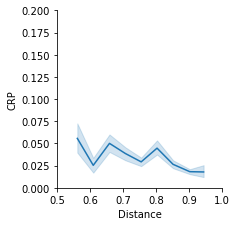

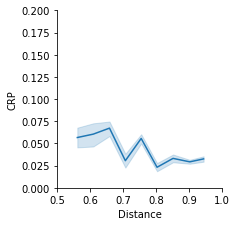

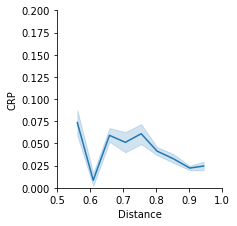

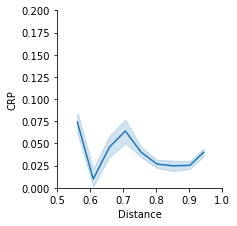

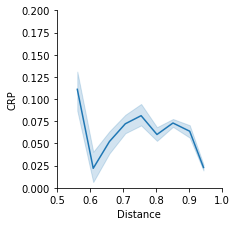

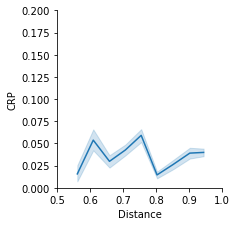

In [219]:


edges = [0.5299, 0.5799, 0.6299, 0.6799, 0.7299, 0.7799, 0.8299, 0.8799, 0.9299, 0.9799]
centers = [0.5620, 0.6102, 0.6593, 0.7073, 0.7552, 0.8032, 0.8516, 0.9023, 0.9440]

for story_name in passage_names:
    
    dcrp = fr.distance_crp(events[events.story_name==story_name], 'item_index', 
                    1-np.array(similarity_result[story_name]), edges, centers)
    g = fr.plot_distance_crp(dcrp, min_samples=5)
    g.set(xlim=(.5, 1), ylim=(0, .2));

    plt.show()
